In [1]:
import json
import pandas as pd
from data_util import load_data, get_tokenizer, tokenize_df, NewsDataset
import seaborn as sns
from collections import Counter
from unidecode import unidecode
import re
import unicodedata
import html
import numpy as np

In [2]:
tokenizer = get_tokenizer()

df = load_data()
df.head()
tokenize_df(df, tokenizer)

9038 articles loaded.


In [3]:
df.head()

,title,description,title_tokens,desc_tokens
0,How Santa Cruz Cities are Approaching Outdated...,The process of changing the gendered pronouns ...,"[How, ĠSanta, ĠCruz, ĠCities, Ġare, ĠAppro, ac...","[The, Ġprocess, Ġof, Ġchanging, Ġthe, Ġg, ende..."
1,"St. David: Saint of the Day for Wednesday, Mar...","According to tradition, St. David was the son ...","[St, ., ĠDavid, :, ĠSaint, Ġof, Ġthe, ĠDay, Ġf...","[According, Ġto, Ġtradition, ,, ĠSt, ., ĠDavid..."
2,WATCH: Kids react to drag with open arms and o...,The video is a heartwarming reminder that the ...,"[WATCH, :, ĠKids, Ġreact, Ġto, Ġdrag, Ġwith, Ġ...","[The, Ġvideo, Ġis, Ġa, Ġheart, warming, Ġremin..."
3,Pink + pink = gold? Hybrid hummingbird's feath...,"The pink-throated brilliant hummingbird, Helio...","[Pink, Ġ+, Ġpink, Ġ=, Ġgold, ?, ĠHybrid, Ġhumm...","[The, Ġpink, -, thro, ated, Ġbrilliant, Ġhummi..."
4,'Poverty is a policy choice': Millions of Amer...,"As of Wednesday, around 30 million people acro...","[', P, overty, Ġis, Ġa, Ġpolicy, Ġchoice, ':, ...","[As, Ġof, ĠWednesday, ,, Ġaround, Ġ30, Ġmillio..."


In [4]:
title_lengths = df.title_tokens.map(len)
desc_lengths = df.desc_tokens.map(len)

# Remove rows with empty title/desc  OR titles that are longer than the desc.
invalid_samples = (title_lengths == 0) | (title_lengths >= desc_lengths)
print(f"{sum(invalid_samples)} invalid samples.")

2497 invalid samples.


In [5]:
def print_stats(name, seq_lengths):
	print(f"{name} len.")
	print(f'\tMin: {min(seq_lengths)}\t\tMax: {max(seq_lengths)}')
	print(f'\tMedian: {np.median(seq_lengths)}\tMean: {int(np.mean(seq_lengths))}\tStddev: {int(np.std(seq_lengths))}')

df_filtered = df[~invalid_samples]
print(f"Sequence length stats. of filtered dataset ({len(df_filtered)} samples):")

title_lengths_filt = df_filtered.title_tokens.map(len)
desc_lengths_filt = df_filtered.desc_tokens.map(len)

print_stats("Title", title_lengths_filt)
print_stats("Desc.", desc_lengths_filt)
print_stats("Total", title_lengths_filt +desc_lengths_filt)

Sequence length stats. of filtered dataset (6541 samples):
Title len.
	Min: 4		Max: 83
	Median: 17.0	Mean: 18	Stddev: 7
Desc. len.
	Min: 9		Max: 194
	Median: 78.0	Mean: 71	Stddev: 28
Total len.
	Min: 17		Max: 207
	Median: 97.0	Mean: 90	Stddev: 31


In [6]:
df_filtered.head()

,title,description,title_tokens,desc_tokens
0,How Santa Cruz Cities are Approaching Outdated...,The process of changing the gendered pronouns ...,"[How, ĠSanta, ĠCruz, ĠCities, Ġare, ĠAppro, ac...","[The, Ġprocess, Ġof, Ġchanging, Ġthe, Ġg, ende..."
1,"St. David: Saint of the Day for Wednesday, Mar...","According to tradition, St. David was the son ...","[St, ., ĠDavid, :, ĠSaint, Ġof, Ġthe, ĠDay, Ġf...","[According, Ġto, Ġtradition, ,, ĠSt, ., ĠDavid..."
2,WATCH: Kids react to drag with open arms and o...,The video is a heartwarming reminder that the ...,"[WATCH, :, ĠKids, Ġreact, Ġto, Ġdrag, Ġwith, Ġ...","[The, Ġvideo, Ġis, Ġa, Ġheart, warming, Ġremin..."
3,Pink + pink = gold? Hybrid hummingbird's feath...,"The pink-throated brilliant hummingbird, Helio...","[Pink, Ġ+, Ġpink, Ġ=, Ġgold, ?, ĠHybrid, Ġhumm...","[The, Ġpink, -, thro, ated, Ġbrilliant, Ġhummi..."
4,'Poverty is a policy choice': Millions of Amer...,"As of Wednesday, around 30 million people acro...","[', P, overty, Ġis, Ġa, Ġpolicy, Ġchoice, ':, ...","[As, Ġof, ĠWednesday, ,, Ġaround, Ġ30, Ġmillio..."


In [7]:
# Remove outliers (> 3 standard dev. from mean)
for col in ['title_tokens', 'desc_tokens']:
	series = df[col].map(len)
	mu, std = np.mean(series), np.std(series)

	df_filtered = df_filtered[series.between(mu - 3*std, mu + 3*std)]

print(f"{len(df_filtered)} samples remaining after removing outliers")

6461 samples remaining after removing outliers


/var/folders/gn/wndrm52n61s3sc5h9q0hgjm40000gn/T/ipykernel_28448/807748911.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[series.between(mu - 3*std, mu + 3*std)]


In [26]:
from torch.utils.data import Dataset
class NewsDataset2(Dataset):

	def __init__(self, df, tokenizer):
		BOS = tokenizer.bos_token
		SEP = tokenizer.sep_token
		PAD = tokenizer.pad_token

		tokens = df.apply(lambda x: [BOS] + x["title_tokens"] + [SEP] + x['desc_tokens'] + [BOS], axis=1)
		max_len = max(tokens.map(len))
		tokens = tokens.apply(lambda x: x + [PAD]* (max_len-len(x)))

		self.token_ids = tokens.map(tokenizer.convert_tokens_to_ids)
		self.title_lens = df.title_tokens.map(len) + 1

	def __len__(self):
		return len(self.token_ids)

	def __getitem__(self,idx):  
		token_ids = torch.tensor(self.token_ids[idx])
		sample = {'token_ids': token_ids, 'sep_pos': self.title_lens[idx]}
		return sample
	
		return sample
	

In [51]:
import torch
from torch.utils.data import  DataLoader

In [58]:
df_filtered = df_filtered.reset_index()
dataset = NewsDataset2(df_filtered, tokenizer)
dataloader = DataLoader(dataset)
for step, batch in enumerate(dataloader):
	inputs, labels = batch['token_ids'], batch['token_ids']


In [59]:
df_filtered.head()

,index,title,description,title_tokens,desc_tokens
0,0,How Santa Cruz Cities are Approaching Outdated...,The process of changing the gendered pronouns ...,"[How, ĠSanta, ĠCruz, ĠCities, Ġare, ĠAppro, ac...","[The, Ġprocess, Ġof, Ġchanging, Ġthe, Ġg, ende..."
1,1,"St. David: Saint of the Day for Wednesday, Mar...","According to tradition, St. David was the son ...","[St, ., ĠDavid, :, ĠSaint, Ġof, Ġthe, ĠDay, Ġf...","[According, Ġto, Ġtradition, ,, ĠSt, ., ĠDavid..."
2,2,WATCH: Kids react to drag with open arms and o...,The video is a heartwarming reminder that the ...,"[WATCH, :, ĠKids, Ġreact, Ġto, Ġdrag, Ġwith, Ġ...","[The, Ġvideo, Ġis, Ġa, Ġheart, warming, Ġremin..."
3,3,Pink + pink = gold? Hybrid hummingbird's feath...,"The pink-throated brilliant hummingbird, Helio...","[Pink, Ġ+, Ġpink, Ġ=, Ġgold, ?, ĠHybrid, Ġhumm...","[The, Ġpink, -, thro, ated, Ġbrilliant, Ġhummi..."
4,4,'Poverty is a policy choice': Millions of Amer...,"As of Wednesday, around 30 million people acro...","[', P, overty, Ġis, Ġa, Ġpolicy, Ġchoice, ':, ...","[As, Ġof, ĠWednesday, ,, Ġaround, Ġ30, Ġmillio..."


<Axes: xlabel='desc_tokens', ylabel='Count'>

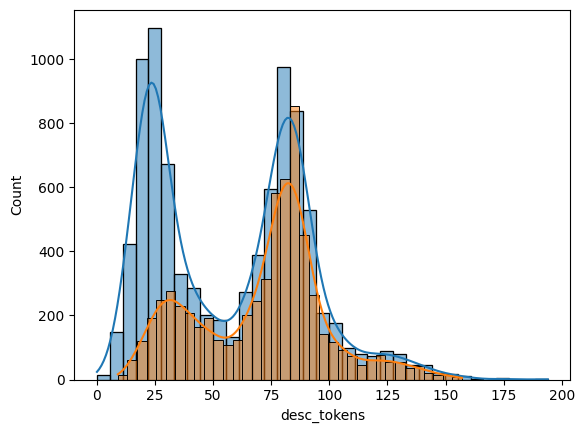

In [13]:
sns.histplot(data = df['desc_tokens'].map(len) , kde = True)
sns.histplot(data = df_filtered['desc_tokens'].map(len) , kde = True)

<Axes: ylabel='Count'>

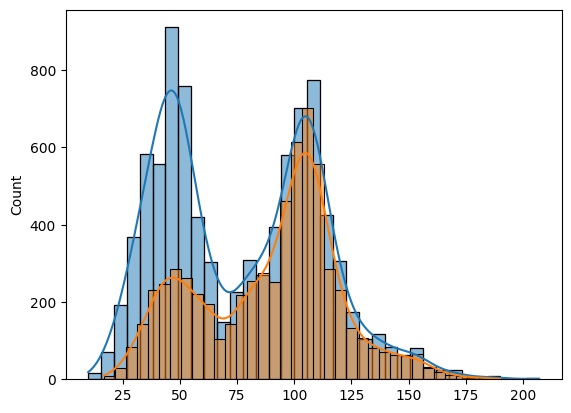

In [45]:
totals = df['desc_tokens'].map(len)  + df['title_tokens'].map(len) 
filtered_totals = df_filtered['desc_tokens'].map(len)  + df_filtered['title_tokens'].map(len) 
sns.histplot(data =totals, kde = True)
sns.histplot(data =filtered_totals, kde = True)

<Axes: xlabel='desc_tokens', ylabel='Count'>

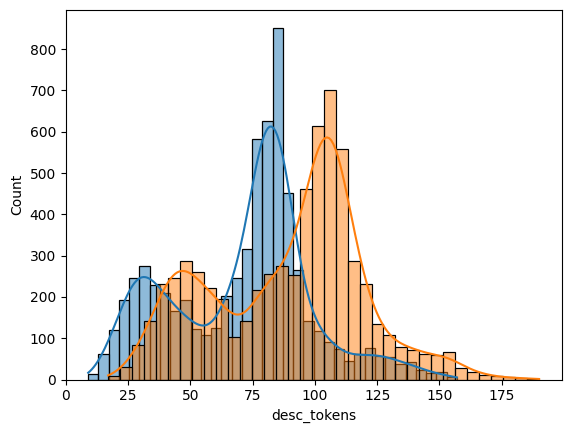

In [9]:
sns.histplot(data = df_filtered['desc_tokens'].map(len) , discrete=False,kde = True)
sns.histplot(data = filtered_totals , discrete=False,kde = True)